In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics, model_selection
import glob
import os
from PIL import Image
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import math
import collections

from efficientnet.tfkeras import EfficientNetB0 as Engine

from albumentations import *


gpus = tf.config.experimental.list_physical_devices('GPU')
num_gpus = len(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(num_gpus, "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
tf.keras.mixed_precision.experimental.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)


1 Physical GPUs, 1 Logical GPUs
Compute dtype: float16
Variable dtype: float32


In [2]:
INCLUDE_EXTERNAL = False

path = '../input/siim-isic-melanoma-classification/'

if INCLUDE_EXTERNAL:
    input_path = '../input/melanoma-all-512x512/'
    train_data = pd.read_csv(path + 'train_all.csv')
    test_data = pd.read_csv(path + 'test_all.csv')
else:
    input_path = '../input/melanoma-512x512/'
    train_data = pd.read_csv(path + 'train.csv')
    test_data = pd.read_csv(path + 'test.csv')
    
submission_data = pd.read_csv(path + 'sample_submission.csv')
test_data['target'] = 0
print("test shape =", test_data.shape)
print(test_data.head(3))
print("\ntrain shape =", train_data.shape)
print(train_data.head(3))

test shape = (10982, 6)
     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_0052060  IP_3579794    male        70.0                           NaN   
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity   
2  ISIC_0058510  IP_7960270  female        55.0                         torso   

   target  
0       0  
1       0  
2       0  

train shape = (33126, 8)
     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  


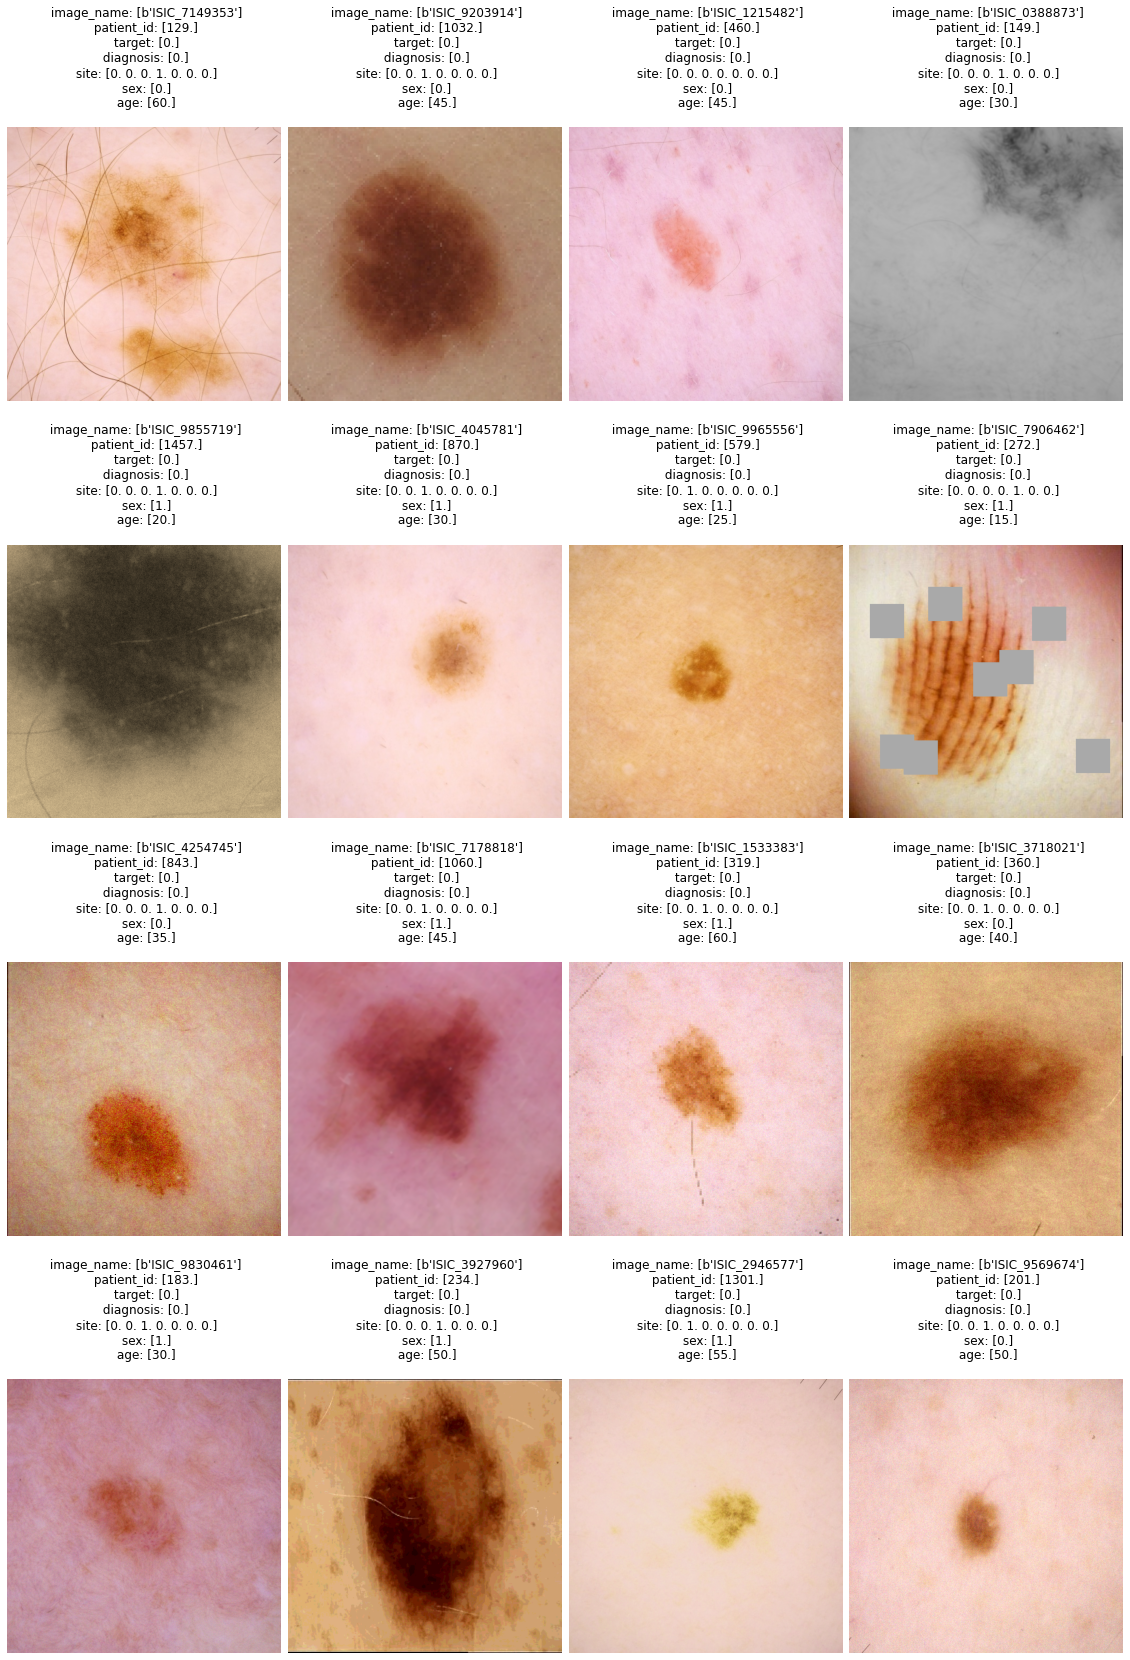

In [3]:
augmentor_heavy = (
    Compose([
        OneOf([
            ShiftScaleRotate(
                shift_limit=0.2,
                scale_limit=0.2,
                rotate_limit=90,
                p=0.3),
            ElasticTransform(
                alpha=601,
                sigma=20,
                alpha_affine=10,
                p=0.3),
            GridDistortion(
                num_steps=5,
                distort_limit=0.3,
                p=0.15),
            OpticalDistortion(
                distort_limit=0.2, 
                shift_limit=0.2,
                p=0.15),
            NoOp(
                p=0.5)
        ]),
        OneOf([
            RandomSizedCrop(
                min_max_height=(300, 512),
                height=512,
                width=512,
                w2h_ratio=0.85,
                p=0.4),
            CoarseDropout(
                max_holes=8, 
                max_height=64, 
                max_width=64,
                fill_value=169,
                p=0.2),
            Downscale(
                scale_min=0.25, 
                scale_max=0.25,
                p=0.2),
            RandomGridShuffle(
                grid=(3, 3),
                p=0.2),
            NoOp(
                p=0.5)
        ]),
        OneOf([
            MedianBlur(
                blur_limit=7,
                p=0.1),
            GaussianBlur(
                blur_limit=7,
                p=0.1),
            Blur(
                blur_limit=7,
                p=0.1),     
            GlassBlur(
                sigma=0.7, 
                max_delta=4, 
                iterations=2,
                p=0.1),
            RandomFog(
                p=0.1),
            Posterize(
                num_bits=4,
                p=0.1),
            NoOp(
                p=0.5),
        ]),
        OneOf([
            GaussNoise(
                var_limit=(10.0, 100.0),
                p=0.2),
            ISONoise(
                color_shift=(0.05, 0.1), 
                intensity=(0.1, 0.5),
                p=0.2),
            NoOp(
                p=0.5)
        ]),
        OneOf([
            RGBShift(
                r_shift_limit=10,
                g_shift_limit=10,
                b_shift_limit=10,
                p=0.25),
            HueSaturationValue(
                hue_shift_limit=10,
                sat_shift_limit=20,
                val_shift_limit=15,
                p=0.25),
            FancyPCA(
                alpha=0.5,
                p=0.1),
            ChannelDropout(
                channel_drop_range=(1, 1),
                p=0.1),
            ToGray(
                p=0.1),
            ToSepia(
                p=0.1),
            NoOp(
                p=0.5)
        ]),
        OneOf([
            RandomBrightnessContrast(
                brightness_limit=0.15,
                contrast_limit=0.15,
                p=0.3),
            RandomGamma(
                gamma_limit=(80, 120),
                p=0.3),
            NoOp(
                p=0.5)
        ]),
        RandomRotate90(
            p=0.5),
        Flip(
            p=0.5),
        Transpose(
            p=0.5),
    ])
)


augmentor_light = (
    Compose([
        RandomSizedCrop(
            min_max_height=(384, 512),
            height=512,
            width=512,
            w2h_ratio=0.85,
            p=0.3),
        RandomRotate90(
            p=0.5),
        Flip(
            p=0.5),
        Transpose(
            p=0.5),
    ])
)



def _parse_record(serialized, features_to_parse):
    features = {}
    for key in features_to_parse:
        if key == 'image_name' or key == 'image':
            features[key] = tf.io.FixedLenFeature(
                [], tf.string, default_value='')
        else:
            features[key] = tf.io.FixedLenFeature(
                [], tf.int64, default_value=0)   
    return tf.io.parse_single_example(
        serialized=serialized, features=features)

def _filter_features_by_image_name(features, image_names):
    '''This function will help divide dataset into train/valid set
    '''
    if image_names is not None:
        if tf.reduce_any(tf.math.equal(features['image_name'], image_names)): 
            return True
        else: 
            return False
    return True
    
def _extract_features(features, features_to_extract):
    extracted = {}
    for key in features_to_extract:
        if key == 'image':
            extracted[key] = tf.io.decode_jpeg(features[key], channels=3)
        else:
            extracted[key] = features[key]
    return extracted

def _resize_image(features, target_image_size, resize_pad):
    if tf.reduce_any(tf.shape(features['image']) != target_image_size):
        if resize_pad:
            features['image'] = tf.image.resize_with_pad(
                features['image'], *target_image_size[:-1], method='bilinear')
        else:
            features['image'] = tf.image.resize(
                features['image'], target_image_size[:-1], method='bilinear')
        features['image'] = tf.cast(features['image'], dtype=tf.uint8)
    return features
    
def _augment_image(mode):
    def transform(*features, mode=mode):
        '''Using albumentations augmentations, which will be 
        wrapped in tf.py_function, is very convenient. However, 
        for better performance, consider using TF operations 
        instead to augment the image data
        '''
        features = list(features)
        if mode == 'heavy':
            features[0] = augmentor_heavy(image=features[0].numpy())['image']
        else:
            features[0] = augmentor_light(image=features[0].numpy())['image']
        return features
    return transform

def _preprocess_features(features):
    for key in features.keys():
        if key == 'image':
            features[key] = tf.cast(features[key], dtype=tf.float32) / 255.
        elif key == 'anatom_site_general_challenge':
            features[key] = tf.cast(tf.one_hot(features[key], 7), tf.float32)
        elif key == 'diagnosis':
            features[key] = tf.cast(tf.one_hot(features[key], 10), tf.float32)
        elif key == 'image_name':
            features[key] = tf.expand_dims(features[key], -1)
        else:
            features[key] = tf.expand_dims(tf.cast(features[key], dtype=tf.float32), -1)
    return features


class InitializeTFRecordDataset:
    
    def __init__(self, 
                 path, 
                 features_to_extract=['image', 'image_name', 'target'],
                 input_shape=(384, 384, 3),
                 batch_size=16,
                 resize_pad=False,
                 augment=None,
                 shuffle=None,
                 cache=None):
        
        if 'image' != features_to_extract[0]:
            raise ValueError("`image` has to be the first element" +
                             " in `features_to_extract` list")
        self.path = path
        self.features_to_extract = features_to_extract
        self.has_target = True if 'train' in self.path.split('/')[-1] else False
        self.image_paths = glob.glob(self.path)
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.resize_pad = resize_pad
        self.augment = augment
        self.shuffle = shuffle
        self.cache = cache
        
    def get(self, image_names=None):
        
        def deconstruct(features):
            return list(features.values())

        def construct(features, keys):
            return dict(zip(keys, features))
        
        if self.cache:
            if not(os.path.isdir('tmp/')):
                os.mkdir('tmp/')
            else:
                files = glob.glob('tmp/*')
                for file in files:
                    os.remove(file)

            if isinstance(self.cache, str):
                cache_path = 'tmp/' + cache
            else:
                cache_path = ''
        
        dataset = tf.data.TFRecordDataset(
            filenames=self.image_paths,
            num_parallel_reads=tf.data.experimental.AUTOTUNE)

        dataset = dataset.map(
            lambda x: _parse_record(
                x, features_to_parse=self.features_to_extract),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)

        dataset = dataset.filter(
            lambda features: _filter_features_by_image_name(
                features, image_names=image_names))

        dataset = dataset.map(
            lambda features: _extract_features(
                features, features_to_extract=self.features_to_extract),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
        
        dataset = dataset.map(
            lambda features: _resize_image(
                features, target_image_size=self.input_shape, resize_pad=self.resize_pad), 
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
        
        if self.cache:
            dataset = dataset.cache(cache_path)

        if self.shuffle:
            dataset = dataset.shuffle(1024)
         
        if self.augment:
            dataset = dataset.map(deconstruct, tf.data.experimental.AUTOTUNE)
            dataset = dataset.map(
                lambda *args: tf.py_function(
                    func=_augment_image(mode=self.augment),
                    inp=args,
                    Tout=[a.dtype for a in args]),
                tf.data.experimental.AUTOTUNE)
            dataset = dataset.map(lambda *args: construct(
                args, keys=self.features_to_extract), tf.data.experimental.AUTOTUNE)
        
        dataset = dataset.batch(self.batch_size)
        
        dataset = dataset.map(_preprocess_features, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        
        return dataset
           
# Test
ds = InitializeTFRecordDataset(
    input_path+'train*', 
    features_to_extract=[
        'image', 'image_name', 'patient_id', 
        'target', 'anatom_site_general_challenge', 
        'sex', 'age_approx', 'diagnosis'
    ],
    input_shape=(512, 512, 3),
    batch_size=16,
    resize_pad=False,
    augment='heavy',
    shuffle=False,
    cache=None
)

ds = ds.get(None)

for inp in ds.take(1): pass
del ds

fig, axes = plt.subplots(4, 4, figsize=(20, 30))

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(inp['image'].numpy()[i]);
    ax.set_title(
        ' image_name: ' + str(inp['image_name'].numpy()[i]) + '\n' + 
        ' patient_id: ' + str(inp['patient_id'].numpy()[i]) + '\n' + 
        ' target: '     + str(inp['target'].numpy()[i]) + '\n' + 
        ' diagnosis: '  + str(inp['target'].numpy()[i]) + '\n' +
        ' site: '       + str(inp['anatom_site_general_challenge'].numpy()[i]) + '\n' + 
        ' sex: '        + str(inp['sex'].numpy()[i]) + '\n' + 
        ' age: '        + str(inp['age_approx'].numpy()[i]) + '\n'
    )
    ax.axis('off')
    
plt.subplots_adjust(hspace=0.1, wspace=0.025)

In [4]:
def sigmoid_focal_cross_entropy_with_logits(
    labels, logits, alpha=0.25, gamma=2.0):
    
    if gamma and gamma < 0:
        raise ValueError("Value of gamma should be greater than or equal to zero")

    logits = tf.convert_to_tensor(logits)
    labels = tf.convert_to_tensor(labels, dtype=logits.dtype)

    # Get the cross_entropy for each entry
    ce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=labels, logits=logits) 

    # If logits are provided then convert the predictions into probabilities
    pred_prob = tf.math.sigmoid(logits)
    
    p_t = (labels * pred_prob) + ((1 - labels) * (1 - pred_prob))
    alpha_factor = 1.0
    modulating_factor = 1.0

    if alpha:
        alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)
        alpha_factor = labels * alpha + (1 - labels) * (1 - alpha)

    if gamma:
        gamma = tf.convert_to_tensor(gamma, dtype=tf.float32)
        modulating_factor = tf.pow((1.0 - p_t), gamma)

    # compute the final loss and return
    return tf.math.reduce_sum(
        alpha_factor * modulating_factor * ce, axis=-1)


class NeuralNet(tf.keras.Model):
    
    def __init__(self, engine, input_shape, pretrained_weights):

        super(NeuralNet, self).__init__()

        self.engine = engine(
            include_top=False,
            input_shape=input_shape,
            weights=pretrained_weights)

        self.pool = tf.keras.layers.GlobalAveragePooling2D()
        self.concat = tf.keras.layers.Concatenate()
        
        self.sequential_meta = tf.keras.Sequential([
            tf.keras.layers.Dense(64),
            tf.keras.layers.ReLU(),
        ])
        
        self.sequential_merged = tf.keras.Sequential([
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, dtype='float32')
        ])
        
        
    def call(self, inputs, **kwargs):
        
        if isinstance(inputs, dict):
            images = inputs['image'] 
            site = inputs['anatom_site_general_challenge']
            sex = inputs['sex']
            age = inputs['age_approx']
        else:
            # when model.build(input_shape) is called
            images = inputs[0]
            site = inputs[1]
            sex = inputs[2]
            age = inputs[3]
        
        x1 = self.engine(images)
        x1 = self.pool(x1)
        x2 = tf.concat([site, sex, age], axis=-1)
        x2 = self.sequential_meta(x2)
        x3 = self.concat([x1, x2])
        x3 = self.sequential_merged(x3)
        return x3
    
    
class DistributedModel:
    
    def __init__(self, 
                 engine,
                 input_shape=(384, 384, 3),
                 pretrained_weights=None,
                 finetuned_weights=None,
                 batch_size=8,
                 optimizer=None, 
                 strategy=None,
                 mixed_precision=False, 
                 label_smoothing=0.0,
                 tta=1,
                 focal_loss=True,
                 save_best=False):
        
        self.keras_model = NeuralNet(
            engine=engine,
            input_shape=input_shape,
            pretrained_weights=pretrained_weights)
        self.keras_model.build(
            [[None, *input_shape], [None, 7], [None, 1], [None, 1]])
        if finetuned_weights:
            self.keras_model.load_weights(finetuned_weights)
        self._initial_weights = self.keras_model.get_weights()
        self.global_batch_size = batch_size
        self.mixed_precision = mixed_precision
        self.optimizer = optimizer
        self.strategy = strategy
        self.label_smoothing = label_smoothing
        self.tta = tta
        self.focal_loss = focal_loss
        self.save_best = save_best
        
        self.auc_metric = tf.keras.metrics.AUC()
        self.loss_metric = tf.keras.metrics.Mean()
        
        if self.optimizer and self.mixed_precision:
            self.optimizer = \
                tf.keras.mixed_precision.experimental.LossScaleOptimizer(
                    optimizer, loss_scale='dynamic')
                
        if self.strategy:
            self.global_batch_size *= self.strategy.num_replicas_in_sync
            
        if not(os.path.isdir('output/weights')) and save_best:
            os.makedirs('output/weights') 
    
    def reset_weights(self):
        self.keras_model.set_weights(self._initial_weights)
    
    def _compute_loss(self, labels, logits):
        if self.focal_loss:
            per_example_loss = sigmoid_focal_cross_entropy_with_logits(
                labels=labels, logits=logits, alpha=0.8, gamma=2.0)
        else:
            per_example_loss = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=labels, logits=logits) 
        return tf.nn.compute_average_loss(
            per_example_loss, global_batch_size=self.global_batch_size)
        
    @tf.function
    def _distributed_train_step(self, dist_inputs):
        
        def train_step(inputs):

            if self.label_smoothing:
                target = (
                    inputs['target'] * (1 - self.label_smoothing)
                    + 0.5 * self.label_smoothing
                )
            else:
                target = inputs['target']

            with tf.GradientTape() as tape:
                
                logits = self.keras_model(inputs, training=True)
                loss = self._compute_loss(target, logits)
                self.loss_metric.update_state(loss)
                self.auc_metric.update_state(
                    tf.math.round(target), tf.math.sigmoid(logits))
                if self.mixed_precision:
                    scaled_loss = self.optimizer.get_scaled_loss(loss)

            if self.mixed_precision:
                scaled_gradients = tape.gradient(
                    scaled_loss, self.keras_model.trainable_variables)
                gradients = self.optimizer.get_unscaled_gradients(scaled_gradients)
            else:
                gradients = tape.gradient(loss, self.keras_model.trainable_variables)

            self.optimizer.apply_gradients(
                zip(gradients, self.keras_model.trainable_variables))

            return loss
        
        per_replica_loss = self.strategy.run(train_step, args=(dist_inputs,))
        return self.strategy.reduce(
            tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
        
    @tf.function
    def _distributed_predict_step(self, dist_inputs):
        
        def predict_step(inputs):
            logits = self.keras_model(inputs, training=False)
            return tf.math.sigmoid(logits), inputs['image_name'], inputs['target']
    
        preds, image_names, trues = self.strategy.run(predict_step, args=(dist_inputs,))
        if tf.is_tensor(preds):
            return [preds], [image_names], [trues]
        else:
            return preds.values, image_names.values, trues.values
    
    def fit(self, ds):

        ds = self.strategy.experimental_distribute_dataset(ds)
        ds = tqdm.tqdm(ds)
        
        for i, inputs in enumerate(ds):
            loss = self._distributed_train_step(inputs)
            epoch_loss = self.loss_metric.result().numpy()
            epoch_auc = self.auc_metric.result().numpy()
            ds.set_description(
                "valid AUC {:.4f} : Loss/AUC [{:.4f}, {:.4f}]".format(
                    self.auc_score, 
                    self.loss_metric.result().numpy(), 
                    self.auc_metric.result().numpy()
                )
            )
            
        self.loss_metric.reset_states()
        self.auc_metric.reset_states()

    def predict(self, ds):

        ds = self.strategy.experimental_distribute_dataset(ds.repeat(self.tta))
        ds = tqdm.tqdm(ds)
        
        preds_accum = np.zeros([0, 1], dtype=np.float32)
        names_accum = np.zeros([0, 1], dtype=str)
        trues_accum = np.zeros([0, 1], dtype=np.float32)
        
        for inputs in ds:
            preds, names, trues = self._distributed_predict_step(inputs)
        
            for pred, name, true in zip(preds, names, trues):
                preds_accum = np.concatenate([preds_accum, pred.numpy()], axis=0)
                names_accum = np.concatenate([names_accum, name.numpy()], axis=0)
                trues_accum = np.concatenate([trues_accum, true.numpy()], axis=0)
        
        preds_accum = preds_accum.reshape((self.tta, -1)).mean(axis=0)
        names_accum = names_accum.reshape((self.tta, -1))[0]
        trues_accum = trues_accum.reshape((self.tta, -1)).mean(axis=0).round()
        
        return preds_accum, names_accum, trues_accum
    
    def fit_and_predict(self, fold, epochs, train_ds, valid_ds, test_ds):
        
        self.auc_score = 0.
        self.best_score = 0.
        for epoch in range(epochs):
            
            # fit for an epoch
            self.fit(train_ds)
            
            # predict on validation set
            valid_preds, valid_names, valid_trues = self.predict(valid_ds)
            
            # compute auc score and save model if best_score
            self.auc_score = metrics.roc_auc_score(valid_trues, valid_preds)
            
            if self.auc_score > self.best_score:
                self.best_score = self.auc_score
                best_valid_preds = valid_preds.copy()
                if self.save_best:
                    self.keras_model.save_weights(f'output/weights/model-{fold}-{epoch}.h5')
                
                # predict on test set
                self.tta = 6
                test_preds, test_names, _ = self.predict(test_ds)
                self.tta = 1
                
        return valid_preds, valid_names, test_preds, test_names 

In [5]:
def get_optimizer(steps_per_epoch, lr_max, lr_min,
                  decay_epochs, warmup_epochs, power=1):

    if decay_epochs > 0:
        learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
            initial_learning_rate=lr_max,
            decay_steps=steps_per_epoch*decay_epochs,
            end_learning_rate=lr_min,
            power=power,
        )
    else:
        learning_rate_fn = lr_max

    if warmup_epochs > 0:
        learning_rate_fn = WarmUp(
            lr_start = lr_min,
            lr_end = lr_max,
            lr_fn = learning_rate_fn,
            warmup_steps=steps_per_epoch*warmup_epochs,
            power=power,
        )

    return tf.keras.optimizers.Adam(learning_rate_fn)


class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, lr_start, lr_end, lr_fn, warmup_steps, power=1):
        super().__init__()
        self.lr_start = lr_start
        self.lr_end = lr_end
        self.lr_fn = lr_fn
        self.warmup_steps = warmup_steps
        self.power = power

    def __call__(self, step):
        global_step_float = tf.cast(step, tf.float32)
        warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)
        warmup_percent_done = global_step_float / warmup_steps_float
        warmup_learning_rate = tf.add(tf.multiply(
            self.lr_start-self.lr_end,
            tf.math.pow(1-warmup_percent_done, self.power)), self.lr_end)
        return tf.cond(
            global_step_float < warmup_steps_float,
            lambda: warmup_learning_rate,
            lambda: self.lr_fn(step),
        )

    def get_config(self):
        return {
            "lr_start": self.lr_start,
            "lr_end": self.lr_end,
            "lr_fn": self.lr_fn,
            "warmup_steps": self.warmup_steps,
            "power": self.power,
        }

In [6]:
# Configurations ------
folds = 5
epochs = 16
batch_size = 12
learning_rate_max = 1e-4
learning_rate_min = 1e-5
learning_rate_decay_epochs = epochs
learning_rate_warmup_epochs = 1
learning_rate_decay_power = 1
# Note: if input_shape is changed, RandomSizedCrop 
# also has to be changed, accordingly.
input_shape = (512, 512, 3)
label_smoothing = 0.05
tta = 1 # tta > 1 only when create_dataset(shuffle=False)
mixed_precision = True # set to True but won't have an effect
focal_loss = False
save_best = False
pretrained_weights = "noisy-student"
finetuned_weights = None
# ---------------------

train_ds_obj = InitializeTFRecordDataset(
    input_path+'train*', 
    features_to_extract=[
        'image', 'image_name', 'target', 
        'anatom_site_general_challenge', 
        'sex', 'age_approx',
    ],
    input_shape=input_shape,
    batch_size=batch_size,
    resize_pad=False,
    augment='heavy',
    shuffle=True,
    cache=None
)
valid_ds_obj = InitializeTFRecordDataset(
    input_path+'train*', 
    features_to_extract=[
        'image', 'image_name', 'target', 
        'anatom_site_general_challenge', 
        'sex', 'age_approx',
    ],
    input_shape=input_shape,
    batch_size=batch_size,
    resize_pad=False,
    augment=None,
    shuffle=None,
    cache=None
)
test_ds_obj = InitializeTFRecordDataset(
    input_path+'test*', 
    features_to_extract=[
        'image', 'image_name', 'target', 
        'anatom_site_general_challenge', 
        'sex', 'age_approx',
    ],
    input_shape=input_shape,
    batch_size=batch_size,
    resize_pad=False,
    augment='light',
    shuffle=None,
    cache=None
)
sss = model_selection.GroupShuffleSplit(
    n_splits=folds, random_state=42).split(
    X=train_data.index, 
    y=train_data.target,
    groups=train_data.patient_id)

# strategy = tf.distribute.MirroredStrategy() # multi-GPU training
strategy = tf.distribute.OneDeviceStrategy(device='GPU') # single-GPU training
# strategy = tf.distribute.OneDeviceStrategy(device='GPU') # CPU training

with strategy.scope():
    
    optimizer = get_optimizer(
        steps_per_epoch=math.ceil((len(train_data)*(1-(1/folds)))/batch_size),
        lr_max=learning_rate_max,
        lr_min=learning_rate_min,
        decay_epochs=learning_rate_decay_epochs,
        warmup_epochs=learning_rate_warmup_epochs,
        power=learning_rate_decay_power
    )
    
    dist_model = DistributedModel(
        engine=Engine,
        input_shape=input_shape,
        pretrained_weights=pretrained_weights,
        finetuned_weights=finetuned_weights,
        batch_size=batch_size,
        optimizer=optimizer, 
        strategy=strategy,
        mixed_precision=mixed_precision, 
        label_smoothing=label_smoothing,
        tta=tta,
        focal_loss=focal_loss,
        save_best=save_best)
    
    valid_preds_accum, test_preds_accum, test_names_accum = list(), list(), list()
    
    for fold, (train_idx, valid_idx) in enumerate(sss):
        
        if fold == 0:
            train_image_names = train_data.iloc[train_idx].image_name.values
            valid_image_names = train_data.iloc[valid_idx].image_name.values

            train_ds = train_ds_obj.get(image_names=train_image_names)
            valid_ds = valid_ds_obj.get(image_names=valid_image_names)
            test_ds = test_ds_obj.get(image_names=None)

            valid_preds, _, test_preds, test_names = dist_model.fit_and_predict(
                fold=fold, 
                epochs=epochs, 
                train_ds=train_ds, 
                valid_ds=valid_ds, 
                test_ds=test_ds, 
            )

            valid_preds_accum.append(valid_preds)
            test_preds_accum.append(test_preds)
            test_names_accum.append(test_names)

            dist_model.reset_weights()


KeyboardInterrupt: 

In [ ]:
final_preds = np.average(test_preds_accum, axis=0) # weights=[..] for weighted avg
final_preds_map = dict(zip(test_names_accum[0].astype('U13'), final_preds))
submission_data['target'] = submission_data.image_name.map(final_preds_map)
submission_data.to_csv('submission.csv', index=False)